Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti
number of samples in the training set: 60000
number of samples in the testing set: 10000
device -> cuda
device -> cuda
Mean accuracy: 89.0%
last accuracy: 98.125%


  0%|                                                                                                                                                                                                                                                  | 0/10 [00:00<?, ?it/s]

For spatial jitter equal to 0.0
Online HOTS accuracy: 8.6 %
Original HOTS accuracy: 10.299999999999999 %
HOTS with homeostasis accuracy: 11.5 %
For spatial jitter equal to 0.27700831024930744
Online HOTS accuracy: 8.4 %
Original HOTS accuracy: 9.0 %
HOTS with homeostasis accuracy: 12.9 %
For spatial jitter equal to 1.1080332409972298
Online HOTS accuracy: 7.3 %
Original HOTS accuracy: 7.7 %
HOTS with homeostasis accuracy: 13.3 %


  0%|                                                                                                                                                                                                                                                  | 0/10 [03:41<?, ?it/s]


KeyboardInterrupt: 

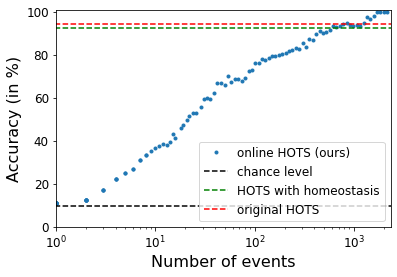

In [1]:
import tonic, torch, os
from hots.network import network
from hots.utils import apply_jitter, get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
    
kfold = None

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.NMNIST(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset, kfold=300)
trainloader = get_loader(trainset, kfold=kfold)
testloader = get_loader(testset, kfold=kfold)
num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')


name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'nmnist'

Rz = [2, 4]
N_neuronz = [16, 32]
tauz = [1e4*2, 1e4*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False)

initial_name_nohomeo = hots_nohomeo.name


filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)
path_nohomeo = '../Records/networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)
    
    
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 1e5

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, verbose=False)

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)

train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
model_path_nohomeo = f'../Records/networks/{hots_nohomeo.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
test_path_nohomeo = f'../Records/output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)

hots_nohomeo.coding(testloader, testset.ordering, testset.classes, training=False, jitter=jitter, verbose=False)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)

likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testoutputloader,results_path,ts_size,testset_output.ordering)
score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])
meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, figure_name = 'nmnist_online.pdf')
print(f'last accuracy: {lastac*100}%')

kfold = 10

standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
apply_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', num_sample_test//kfold, n_classes, hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, kfold = kfold, verbose=True);


standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
apply_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', num_sample_test//kfold, n_classes, hots,hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs,  kfold = kfold, verbose=True)